# Extract secondary structure from PDB files easily and generate spreadsheet

<a rel="license" href="https://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://licensebuttons.net/l/by-sa/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Author: Dr Antonia Mey   
Email: antonia.mey@ed.ac.uk

In [1]:
# Imports
import pandas as pd
import numpy as np
import glob 
import os
import urllib
from collections import Counter
import urllib
import json
import matplotlib.pylab as plt

In [2]:
def get_domainn_region_info(data):
    known_things = {}
    known_things['Domain'] = []
    known_things['Region'] = []
    known_things['Motif'] = []
    #known_things['Helix'] = []
    if 'features' in data.keys():
        for d in data['features']:
            #print(d['type'])
            if d['type'] == 'Domain':
                known_things['Domain'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])            
    return known_things       

In [3]:
def feature_in_domain(domain_mask, start, end, percent_overlap=50):
    second_bool_array = np.zeros(len(domain_mask), dtype=bool)
    second_bool_array[start:end] = True
    overlap = (np.sum(np.logical_and(domain_mask, second_bool_array)))
    if overlap/(end-start)*100>=percent_overlap:
        return True
    else:
        return False 
    

In [4]:
def get_domain_mask(domain_dic, sequence_length):
    bool_array =  np.zeros(sequence_length, dtype=bool)
    for key in domain_dic.keys():
        for entry in known_things[key]:
            # print(f'checking entry {entry}')
    
            if entry[0] is None:
                continue
            elif entry[1] is None:
                continue
            bool_array[entry[0]-1:entry[1]] = True
    return bool_array

In [5]:
def get_domain_name(start, end, domain_dic):
    for d in domain_dic['Domain']:
        if (max(0, min(d[1], end) - max(d[0], start)))>0:
            return d[2]

## Testing things out

In [6]:
# This is from the reviewed table from 2023
f = open('data_idr/all_uni_prot_ids.txt', 'r')
f_content = f.readlines()
f.close()

In [91]:
f = open('uni_prot_ids/swissprot', 'r')
f_content = f.readlines()
f.close()

In [92]:
ids = []
for f in f_content:
    ids.append(f.strip())

In [9]:
fail_list = []
verbose = False

In [10]:
# Process uniprot file
f = open('unique_ids/Q8TAD8.json')
data = json.load(f)
f.close()

# print('read json file successfully')

# Some basics:
# checking keys
keys = data.keys()

# Primary Accession
uni_id = 'NA'
if 'primaryAccession' in keys:
    uni_id = data['primaryAccession'] 
    if verbose:
         print('uni_id',uni_id)
else: 
    print('Issue: No primary Accession found')

# Genes
gene_name = 'NA'
if 'genes' in keys:
    gene_name = data['genes'][0]['geneName']['value']
    if verbose:
        print('gene_name',gene_name)
else:
    print('Issue: No gene found found')

In [11]:
def populate_as_occurances(sequence, domain_name):
    # initalise AS count dictionary
    as_count = {}
    as_count['A'] = 0
    as_count['B'] = 0
    as_count['C'] = 0
    as_count['D'] = 0
    as_count['E'] = 0
    as_count['F'] = 0
    as_count['G'] = 0
    as_count['H'] = 0
    as_count['I'] = 0
    as_count['K'] = 0
    as_count['L'] = 0
    as_count['M'] = 0
    as_count['N'] = 0
    as_count['P'] = 0
    as_count['Q'] = 0
    as_count['R'] = 0
    as_count['S'] = 0
    as_count['T'] = 0
    as_count['V'] = 0
    as_count['W'] = 0
    as_count['Y'] = 0
    as_count['Z'] = 0
    res = Counter(sequence)
    for key in res.keys():
        as_count[key] = res[key]
    return as_count



In [98]:
desired_features = ['Beta strand','Helix','Turn']

# get domain inforamtion
known_things = {}
final_table_list = []   
to_download = []
#ids = ['Q8TAD8']    
ids = ['A0FGR8']
            
# loop over all uniprot ids
for i in range(len(ids)):
#for i in range(30):
    # Process uniprot file
    fname = 'unique_ids/'+ids[i]+'.json'


    if os.path.isfile(fname):
        f = open(fname)
        data = json.load(f)
        f.close()

        known_things = get_domainn_region_info(data)
        print(known_things)
        
        keys = data.keys()

        sequence_length = data['sequence']['length']
        sequence = data['sequence']['value']
        print(sequence)

        # populate dictionary:
        #print(f"sequence length is: {sequence_length}")
        gene_name = 'NA'
        if 'genes' in keys:
            gene_name = data['genes'][0]['geneName']['value']
            
        #print(f"gene name: {gene_name}")
        
        uni_id = 'NA'
        if 'primaryAccession' in keys:
            uni_id = data['primaryAccession'] 
        #print('uni_id',uni_id)
    

        if 'features' in keys:
            
            # populate domain information
            for d in data['features']:
                #print(d['type'])
                if d['type'] == 'Domain':
                    known_things['Domain'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])
            
            domain_mask = get_domain_mask(known_things,sequence_length)

            #if len(final_table_list)>0:
            #    final_table_list[-1]['gap'] = final_table_list[-1]['sequence length']-final_table_list[-1]['end']
            
            # now check secondary structure features and if there is overlap
            starts = []
            ends = []
            count = 0
            gap = None
            for f in data['features']:
                if f['type'] in desired_features:
                    final_table_dic = {}
                    # print('=====New feature====')
                    # print(f['type'])

                    start = f['location']['start']['value']
                    end = f['location']['end']['value']

                    # Check if features is in domain
                    if feature_in_domain(domain_mask, start, end, percent_overlap=50):
                        domain_feature_overalp = 'Yes'
                        domain_name = get_domain_name(start,end,known_things)
                        domain_start = known_things['Domain'][0][0]
                        domain_end = known_things['Domain'][0][1]
                    else:
                        domain_feature_overalp = 'No'  
                        domain_name = 'None'
                        domain_start = 'None'
                        domain_end = 'None'
                    

                    if len(ends)>0:
                        gap = start-ends[-1]
                    #elif count == len(data['features'])-1:
                    #    print('this happens')
                    #    gap = (sequence_length-end)
                    #else:
                    #    gap = start
                    feature_length = end - start
                    final_table_dic['gene name'] = gene_name
                    final_table_dic['Uniprot ID'] = uni_id
                    final_table_dic['sequence length'] = sequence_length
                    final_table_dic['Feature name'] = f['type']
                    final_table_dic['start'] = start
                    final_table_dic['end'] = end
                    final_table_dic['length'] = feature_length
   
                    
                    
                    if gap is None:
                        final_table_dic['gap left'] = gap
                    else:
                        final_table_dic['gap left'] = int(gap)
                    final_table_dic['Overlap with domain'] = domain_feature_overalp
                    final_table_dic['Domain name'] = domain_name
                    final_table_dic['Domain start'] = domain_start
                    final_table_dic['domain end'] = domain_end

                    # count occurances of AS in sequence section if we label it EFD
                    as_count = populate_as_occurances(sequence[start-1:end-1], domain_name)   
                    final_table_dic.update(as_count)
                    if verbose: 
                        print(f"start: {start}")
                        print(f"end: {end}")
                        print(f"length: {feature_length}")
                        print(f"gap: {gap}")
                        print(f"Domain feature overlap: {domain_feature_overalp}")
                        print(f"domain name: {domain_name}")
                    starts.append(start)
                    ends.append(end)
                    print(final_table_dic)
                    final_table_list.append(final_table_dic)
                    count+=1
            starts = np.array(starts)
            ends = np.array(ends)
            gaps = (starts[1:-1]-ends[0:-2])-1
    else:
        #print(f"{fname} does not exist")
        to_download.append(ids[i])


{'Domain': [[191, 370, 'SMP-LTD'], [369, 489, 'C2 1'], [514, 639, 'C2 2'], [786, 908, 'C2 3']], 'Region': [], 'Motif': []}
MTANRDAALSSHRHPGCAQRPRTPTFASSSQRRSAFGFDDGNFPGLGERSHAPGSRLGARRRAKTARGLRGHRQRGAGAGLSRPGSARAPSPPRPGGPENPGGVLSVELPGLLAQLARSFALLLPVYALGYLGLSFSWVLLALALLAWCRRSRGLKALRLCRALALLEDEERVVRLGVRACDLPAWVHFPDTERAEWLNKTVKHMWPFICQFIEKLFRETIEPAVRGANTHLSTFSFTKVDVGQQPLRINGVKVYTENVDKRQIILDLQISFVGNCEIDLEIKRYFCRAGVKSIQIHGTMRVILEPLIGDMPLVGALSIFFLRKPLLEINWTGLTNLLDVPGLNGLSDTIILDIISNYLVLPNRITVPLVSEVQIAQLRFPVPKGVLRIHFIEAQDLQGKDTYLKGLVKGKSDPYGIIRVGNQIFQSRVIKENLSPKWNEVYEALVYEHPGQELEIELFDEDPDKDDFLGSLMIDLIEVEKERLLDEWFTLDEVPKGKLHLRLEWLTLMPNASNLDKVLTDIKADKDQANDGLSSALLILYLDSARNLPSGKKISSNPNPVVQMSVGHKAQESKIRYKTNEPVWEENFTFFIHNPKRQDLEVEVRDEQHQCSLGNLKVPLSQLLTSEDMTVSQRFQLSNSGPNSTIKMKIALRVLHLEKRERPPDHQHSAQVKRPSVSKEGRKTSIKSHMSGSPGPGGSNTAPSTPVIGGSDKPGMEEKAQPPEAGPQGLHDLGRSSSSLLASPGHISVKEPTPSIASDISLPIATQELRQRLRQLENGTTLGQSPLGQIQLTIRHSSQRNKLIVVVHACRNLIAFSEDGSDPYVRMYLLPDKRRSGRRKTHVSKKTLNPVFDQSFDFSVSLPEVQRRTLDVAVKNS

In [99]:
domain_list = []
ends = []
starts = []
for i in range(len(final_table_list)):
    d = final_table_list[i]
    domain_list.append(d['Domain name'])
    ends.append(d['end'])
    starts.append(d['start'])
no_domain=np.where(np.array(domain_list) == 'None')[0].tolist()
known_domain=np.where(np.array(domain_list) != 'None')[0].tolist()

In [149]:
from itertools import groupby

def count_boolean_blocks(arr):
    true_blocks = sum(1 for k, g in groupby(arr) if k)
    false_blocks = sum(1 for k, g in groupby(arr) if not k)
    
    return true_blocks, false_blocks

In [135]:
domain= np.array(domain_list)
ends = np.array(ends)
starts = np.array(starts)

In [136]:
test_domain = domain != "None"
test_none = domain == "None"

In [137]:
domain_pos = np.where(test_domain)[0]

In [138]:
domain_pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [155]:
test_domain

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [156]:
test_none

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False])

In [178]:
domain_index = []
for i in range(len(domain_list)):
    domain_index.append(i)

In [181]:
def splitByMask(a, mask):
    return np.split(a, np.flatnonzero(np.diff(mask)) + 1)
splitted_index = splitByMask(domain_index, test_none)
splitted_label = splitByMask(domain_list, test_none)

In [182]:
splitted_index

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 array([25, 26]),
 array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]),
 array([41]),
 array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51])]

In [188]:
backwards_first = False
if splitted_label[0][0] == None:
    backward_first = True

In [189]:
backwards_first

False

In [195]:
cnt = 1
myendpos = np.where(test_none)[0]
myendvals = ends[myendpos]
for i,d in enumerate(splitted_index):
    if backwards_first:

        s = domain_pos[0]
    
        myhits = np.logical_and(s-myendvals<40, s-myendvals>0)
        myabspos = myendpos[myhits]
        print(len(myabspos))
        print(myabspos)
        if len(myabspos)>0:
            print('yes')
            domain[myabspos] = f"ED{cnt}"
            cnt += 1
    # forward first
    else:
        print(d)
        s = ends[d[-1]]
        myhits = np.logical_and(myendvals-s<40, myendvals-s>0)
        myabspos = myendpos[myhits]
        print(len(myabspos))
        print(myabspos)
        if len(myabspos)>0:
            print('yes')
            domain[myabspos] = f"ED{cnt}"
            cnt += 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
2
[25 26]
yes
[25 26]
0
[]
[27 28 29 30 31 32 33 34 35 36 37 38 39 40]
1
[41]
yes
[41]
0
[]
[42 43 44 45 46 47 48 49 50 51]
0
[]


In [196]:
domain

array(['SMP-LTD', 'SMP-LTD', 'SMP-LTD', 'SMP-LTD', 'SMP-LTD', 'SMP-LTD',
       'SMP-LTD', 'SMP-LTD', 'SMP-LTD', 'SMP-LTD', 'SMP-LTD', 'SMP-LTD',
       'SMP-LTD', 'SMP-LTD', 'C2 1', 'C2 1', 'C2 1', 'C2 1', 'C2 1',
       'C2 1', 'C2 1', 'C2 1', 'C2 1', 'C2 1', 'C2 1', 'ED1', 'ED1',
       'C2 2', 'C2 2', 'C2 2', 'C2 2', 'C2 2', 'C2 2', 'C2 2', 'C2 2',
       'C2 2', 'C2 2', 'C2 2', 'C2 2', 'C2 2', 'C2 2', 'ED2', 'C2 3',
       'C2 3', 'C2 3', 'C2 3', 'C2 3', 'C2 3', 'C2 3', 'C2 3', 'C2 3',
       'C2 3'], dtype='<U7')

In [153]:
cnt = 1
myendpos = np.where(test_none)[0]
myendvals = ends[myendpos]
for d in range(num_domains):

    s = domain_pos[0]

    myhits = np.logical_and(s-myendvals<40, s-myendvals>0)
    myabspos = myendpos[myhits]
    print(len(myabspos))
    print(myabspos)
    if len(myabspos)>0:
        print('yes')
        domain[myabspos] = f"ED{cnt}"
        cnt += 1
    

0
[]
0
[]
0
[]


In [73]:
domain

array(['None', 'None', 'ED1', 'ED3', 'FHA', 'FHA', 'FHA', 'FHA', 'FHA',
       'None', 'None'], dtype='<U4')

## Check if things need to be downloaded

In [29]:
len(to_download)

0

In [30]:
if len(to_download) > 0:
    f = open('data_idr/missing_ids', 'w')
    for id in to_download:
        f.write(id+'\n')
    f.close()

## Finalising the table

In [94]:
df = pd.DataFrame(final_table_list)  

In [95]:
df

,gene name,Uniprot ID,sequence length,Feature name,start,end,length,gap left,Overlap with domain,Domain name,...,N,P,Q,R,S,T,V,W,Y,Z
0,RBM47,A0AV96,593,Beta strand,150,156,6,NaN,Yes,RRM 2,...,1,0,0,1,0,0,0,0,0,0
1,RBM47,A0AV96,593,Helix,164,174,10,8.0,Yes,RRM 2,...,0,0,0,1,0,0,0,0,0,0
2,RBM47,A0AV96,593,Beta strand,178,182,4,4.0,Yes,RRM 2,...,0,0,0,0,0,0,2,0,0,0
3,RBM47,A0AV96,593,Beta strand,185,187,2,3.0,Yes,RRM 2,...,0,0,0,0,1,0,0,0,0,0
4,RBM47,A0AV96,593,Turn,189,193,4,2.0,Yes,RRM 2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,MED19,A0JLT2,244,Helix,90,96,6,4.0,No,None,...,1,0,1,0,0,0,0,0,1,0
80,MED19,A0JLT2,244,Helix,112,116,4,16.0,No,None,...,0,1,0,0,0,0,0,0,0,0
81,MED19,A0JLT2,244,Turn,117,119,2,1.0,No,None,...,0,0,0,0,0,0,0,0,0,0
82,MED19,A0JLT2,244,Helix,128,138,10,9.0,No,None,...,0,2,0,1,1,0,0,0,0,0


In [96]:
df.to_csv('test_18_04_2023.csv', index=False)

In [29]:
df[df['Uniprot ID']=='P11309']

,gene name,Uniprot ID,sequence length,Feature name,start,end,length,gap left,Overlap with domain,Domain name


In [16]:
df.to_csv('all_human_28_03_24.csv', index=False)

<Axes: xlabel='gap left', ylabel='Count'>

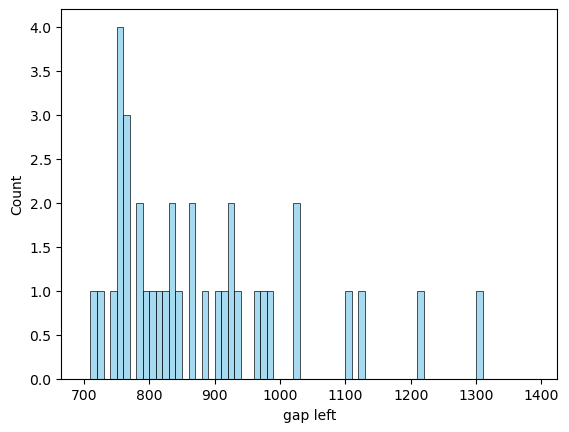

In [16]:
import seaborn as sbn
sbn.histplot(df['gap left'], bins=np.arange(700, 1400, 10), kde=False, color='skyblue')
#plt.yscale('log')

### Getting list of uniprot IDS that are expressed in cells

In [17]:
df = pd.read_csv('filtered_table_final_100223.csv')

In [183]:
selected_rows = df[df['HEK293T_expressed'] == 1]

In [20]:
selected_rows = df

In [21]:
ids_to_be_used = selected_rows['uniprot_id'].values
ids_to_be_used = np.unique(ids_to_be_used)
f = open('data_idr/expressed_uni_prot_ids.txt','w')
for uni in ids_to_be_used:
    f.write(uni+'\n')
f.close()

In [22]:
## all of the data
ids_to_be_used = df['uniprot_id'].values
ids_to_be_used = np.unique(ids_to_be_used)
f = open('data_idr/all_uni_prot_ids.txt','w')
for uni in ids_to_be_used:
    f.write(uni+'\n')
f.close()

In [21]:
df[df['Uniprot ID']=='P11309']

,gene name,Uniprot ID,sequence length,Feature name,start,end,length,gap left,Overlap with domain,Domain name


## Original processing

In [ ]:
desired_features = ['Beta strand','Helix','Turn']

# get domain inforamtion
known_things = {}
final_table_list = []   
to_download = []
ids = ['Q8TAD8']    
ids = ['A0JLT2']
            
# loop over all uniprot ids
for i in range(len(ids)):
#for i in range(20):
    # Process uniprot file
    fname = 'unique_ids/'+ids[i]+'.json'


    if os.path.isfile(fname):
        f = open(fname)
        data = json.load(f)
        f.close()

        known_things = get_domainn_region_info(data)
        #print(known_things)
        
        keys = data.keys()

        sequence_length = data['sequence']['length']

        # populate dictionary:
        #print(f"sequence length is: {sequence_length}")
        gene_name = 'NA'
        if 'genes' in keys:
            gene_name = data['genes'][0]['geneName']['value']
            
        #print(f"gene name: {gene_name}")
        
        uni_id = 'NA'
        if 'primaryAccession' in keys:
            uni_id = data['primaryAccession'] 
        #print('uni_id',uni_id)
    

        if 'features' in keys:
            
            # populate domain information
            for d in data['features']:
                #print(d['type'])
                if d['type'] == 'Domain':
                    known_things['Domain'].append([d['location']['start']['value'], d['location']['end']['value'], d['description']])
            
            domain_mask = get_domain_mask(known_things,sequence_length)

            #if len(final_table_list)>0:
            #    final_table_list[-1]['gap'] = final_table_list[-1]['sequence length']-final_table_list[-1]['end']
            
            # now check secondary structure features and if there is overlap
            starts = []
            ends = []
            count = 0
            gap = None
            for f in data['features']:
                if f['type'] in desired_features:
                    final_table_dic = {}
                    # print('=====New feature====')
                    # print(f['type'])

                    start = f['location']['start']['value']
                    end = f['location']['end']['value']

                    # Check if features is in domain
                    if feature_in_domain(domain_mask, start, end, percent_overlap=50):
                        domain_feature_overalp = 'Yes'
                        domain_name = get_domain_name(start,end,known_things)
                    else:
                        domain_feature_overalp = 'No'  
                        domain_name = 'None'
                    

                    if len(ends)>0:
                        gap = start-ends[-1]
                    #elif count == len(data['features'])-1:
                    #    print('this happens')
                    #    gap = (sequence_length-end)
                    #else:
                    #    gap = start
                    feature_length = end - start
                    final_table_dic['gene name'] = gene_name
                    final_table_dic['Uniprot ID'] = uni_id
                    final_table_dic['sequence length'] = sequence_length
                    final_table_dic['Feature name'] = f['type']
                    final_table_dic['start'] = start
                    final_table_dic['end'] = end
                    final_table_dic['length'] = feature_length
                    if gap is None:
                        final_table_dic['gap left'] = gap
                    else:
                        final_table_dic['gap left'] = int(gap)
                    final_table_dic['Overlap with domain'] = domain_feature_overalp
                    final_table_dic['Domain name'] = domain_name
                    if verbose: 
                        print(f"start: {start}")
                        print(f"end: {end}")
                        print(f"length: {feature_length}")
                        print(f"gap: {gap}")
                        print(f"Domain feature overlap: {domain_feature_overalp}")
                        print(f"domain name: {domain_name}")
                    starts.append(start)
                    ends.append(end)
                    final_table_list.append(final_table_dic)
                    count+=1
            starts = np.array(starts)
            ends = np.array(ends)
            gaps = (starts[1:-1]-ends[0:-2])-1
    else:
        #print(f"{fname} does not exist")
        to_download.append(ids[i])
